In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('..')

import cv2
import torch
import numpy as np
from PIL import Image
from transformers import T5EncoderModel, T5Tokenizer
from diffusers import CogVideoXDDIMScheduler, CogVideoXDPMScheduler, AutoencoderKLCogVideoX
from diffusers.utils import load_video, export_to_video
from denku import show_images, add_mask_on_image
from controlnet_aux import CannyDetector, HEDdetector

from controlnet_pipeline import ControlnetCogVideoXPipeline
from cogvideo_transformer import CustomCogVideoXTransformer3DModel
from cogvideo_controlnet import CogVideoXControlnet

%load_ext autoreload
%autoreload 2

In [2]:
pretrained_model_name_or_path = "THUDM/CogVideoX-2b"

tokenizer = T5Tokenizer.from_pretrained(
    pretrained_model_name_or_path, subfolder="tokenizer"
)

text_encoder = T5EncoderModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)

transformer = CustomCogVideoXTransformer3DModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="transformer"
)

vae = AutoencoderKLCogVideoX.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)

scheduler = CogVideoXDDIMScheduler.from_pretrained(
    pretrained_model_name_or_path, subfolder="scheduler"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
controlnet = CogVideoXControlnet.from_pretrained('TheDenk/cogvideox-2b-controlnet-hed-v1')

In [4]:
pipe = ControlnetCogVideoXPipeline(
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    transformer=transformer,
    vae=vae,
    controlnet=controlnet,
    scheduler=scheduler,
)
pipe = pipe.to(dtype=torch.float16, device='cuda')

pipe.enable_model_cpu_offload()
pipe.enable_sequential_cpu_offload()

In [5]:
controlnet_processor = HEDdetector.from_pretrained("lllyasviel/Annotators").to(device='cuda')

/home/user/Projects/denk_baseline/venv/lib/python3.10/site-packages/controlnet_aux/hed/__init__.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netNetwork.load_state_di

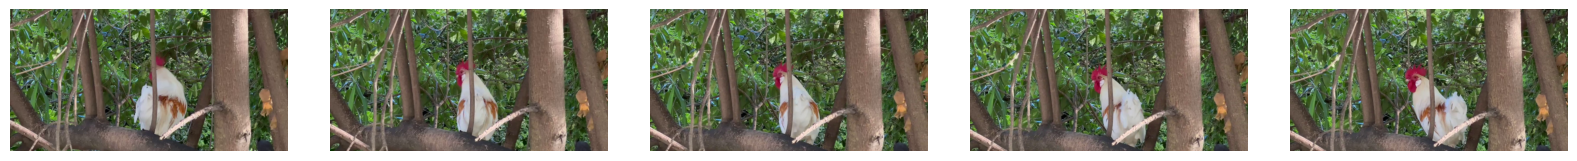

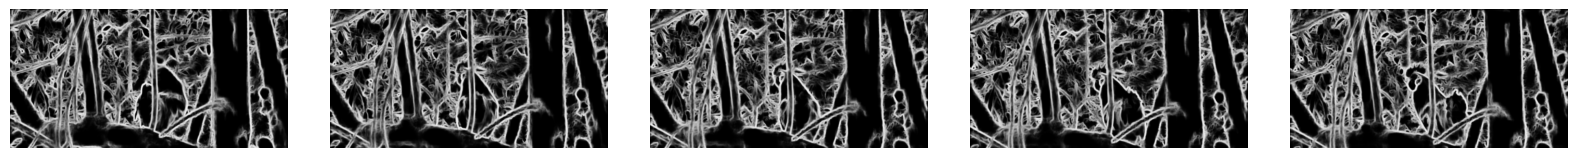

In [6]:
num_frames = 49
video_path = '../resources/cock.MOV'
video_frames = load_video(video_path)[:num_frames]
controlnet_frames = [controlnet_processor(x) for x in video_frames]

show_images(video_frames[::10], figsize=(16, 8))
show_images(controlnet_frames[::10], figsize=(16, 8))

In [7]:
output = pipe(
    controlnet_frames=controlnet_frames,
    prompt='anime, hayomiodzaki, macoto syncaky, cock in the forest',
    height=480,
    width=720,
    num_frames=num_frames,
    guidance_scale=6,
    num_inference_steps=50,
    generator=torch.Generator(device="cuda").manual_seed(42),
    controlnet_weights=1.0,
    controlnet_guidance_start=0.0,
    controlnet_guidance_end=1.0,
)

  0%|          | 0/50 [00:00<?, ?it/s]

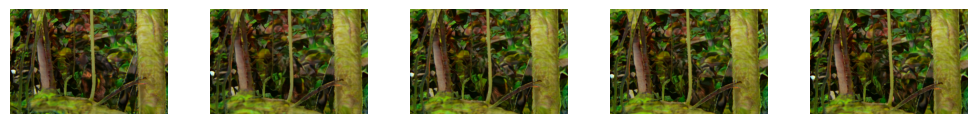

In [8]:
show_images(output.frames[0][::10], figsize=(10, 10))

In [9]:
export_to_video(output.frames[0], 'out.mp4', fps=16)

'out.mp4'

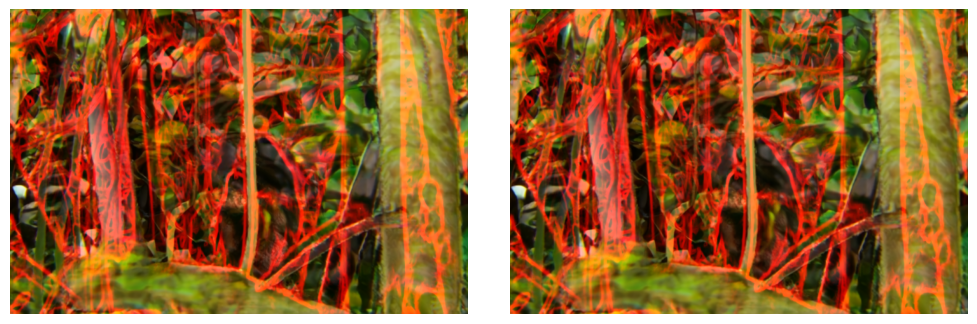

In [10]:
np_predict = [np.array(x) for x in output.frames[0]]

masked_images = [
    add_mask_on_image(
        np.array(image), 
        np.array(mask.resize((720, 480))), 
        color=(255, 0, 0)
    ) 
    for image, mask in zip(np_predict, controlnet_frames)
]
show_images(masked_images[:2], figsize=(10, 10))

In [17]:
export_to_video([Image.fromarray(x) for x in masked_images], 'masked_out.mp4', fps=16)

'masked_out.mp4'